<a href="https://colab.research.google.com/github/samsatp/NLP-contest3/blob/main/contest3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/samsatp/NLP-contest3.git

!gdown 1LGWy5VGVk6TXz_ZaYwGBvwJc5vFBzeZe
!unzip /content/data.zip
!rm /content/data.zip

Cloning into 'NLP-contest3'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 31 (delta 11), reused 20 (delta 6), pack-reused 0
Unpacking objects: 100% (31/31), done.
Downloading...
From: https://drive.google.com/uc?id=1LGWy5VGVk6TXz_ZaYwGBvwJc5vFBzeZe
To: /content/data.zip
100% 24.1M/24.1M [00:00<00:00, 188MB/s]
Archive:  /content/data.zip
  inflating: dev_auto_tok.tsv        
  inflating: dev_entities.json       
  inflating: newly_tokenized/dev_auto_tok.tsv  
  inflating: newly_tokenized/dev_entities.json  
  inflating: newly_tokenized/train_auto_tok.tsv  
  inflating: newly_tokenized/train_entities.json  
  inflating: raw/dev_set.txt         
  inflating: raw/test_set.txt        
  inflating: train_auto_tok.tsv      
  inflating: train_entities.json     


In [2]:
!mkdir /content/result
!mkdir /content/models

In [3]:
import importlib  
preprocess = importlib.import_module("NLP-contest3.util.preprocess")
lst20utils = importlib.import_module("NLP-contest3.lst20utils")


train_seqs = preprocess.get_sequence("/content/train_auto_tok.tsv")
dev_seqs = preprocess.get_sequence("/content/dev_auto_tok.tsv")

In [4]:
X_train_raw = [
                '|'.join([e[0] for e in row])
                for row in train_seqs
            ]

Y_train_raw = [
                [e[1] for e in row]
                for row in train_seqs
            ]

X_dev_raw = [
                '|'.join([e[0] for e in row]) 
                for row in dev_seqs
            ]

Y_dev_raw = [
                [e[1] for e in row]
                for row in dev_seqs
            ]

In [33]:
tags = ['I_LOC', 'B_LOC', 'B_MEA', 'B_NUM', 'I_ORG', 'I_DES', 'I_MEA', 'B_TRM', 'B_DTM', 'B_DES', 'B_BRN', 'I_PER', 'I_NUM', 'B_ORG', 'I_DTM', 'I_BRN', 'B_PER', 'I_TRM', 'I_TTL', 'B_TTL']

sample of raw data

In [5]:
X_train_raw[0], Y_train_raw[0]

('ธรรมนูญ|แชมป์|สิงห์|คลาสสิก|กวาด|รางวัล|แสน|สี่|หมื่น|บาท',
 ['B_PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

Find the appropriate sequence length to pad, truncate

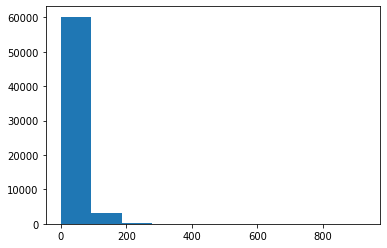

In [6]:
len_seqs = [ e.count("|") for e in X_train_raw]

import matplotlib.pyplot as plt
plt.hist(len_seqs);

In [7]:
import numpy as np
print(np.mean(len_seqs))
print(np.median(len_seqs))

38.92836834623282
33.0


# 1. Data class

In [8]:
import tensorflow as tf

class SeqData:
    def __init__(self, X, Y, maxlen):
        self.X = X 
        self.Y = Y
        self.maxlen = maxlen
        self.inp_tokenizer = tf.keras.preprocessing.text.Tokenizer(
                            filters='',
                            lower=False,
                            split='|',
                            char_level=False,
                            oov_token='<OOV>'
                        )
        self.tag_tokenizer = tf.keras.preprocessing.text.Tokenizer(
                            filters='',
                            lower=False,
                            oov_token='<OOV>'
                        )
        self.inp_tokenizer.fit_on_texts(X)
        self.tag_tokenizer.fit_on_texts(Y)
    
    def padding(self, seqs, dtype='int32', value=0.0):
        return tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post', truncating='post', maxlen=self.maxlen, dtype=dtype, value=value)

    def preprocess_X(self, X):
        tokens = self.inp_tokenizer.texts_to_sequences(X)
        tokens_pad =  self.padding(tokens)
        return tokens_pad

    def preprocess_Y(self, Y):
        tags   = self.tag_tokenizer.texts_to_sequences(Y)
        tags_pad   =  self.padding(tags)
        return tags_pad

    def preprocess(self, X, Y):
        return self.preprocess_X(X), self.preprocess_Y(Y)

    def load_dataset(self, X, Y, BATCH_SIZE):

        tokens, targets = self.preprocess(X, Y)

        # create dataset
        if BATCH_SIZE:
            dataset = tf.data.Dataset.from_tensor_slices((tokens, targets))\
                        .shuffle(1000)\
                        .batch(BATCH_SIZE, drop_remainder=True)
        else:
            dataset = tf.data.Dataset.from_tensor_slices((tokens, targets))\
                        .shuffle(1000)\
                        .batch(len(X_dev_raw), drop_remainder=True)


        return dataset, self.inp_tokenizer, self.tag_tokenizer

In [9]:
data_creator = SeqData(X_train_raw, Y_train_raw, maxlen=100)

train_dataset, inp_tokenizer, tag_tokenizer = data_creator.load_dataset(X_train_raw, Y_train_raw, 32)
dev_dataset, _, _ = data_creator.load_dataset(X_dev_raw, Y_dev_raw, BATCH_SIZE=None)

In [10]:
example_X_batch, example_Y_batch = next(iter(train_dataset))
print(example_X_batch.shape, example_Y_batch.shape)

(32, 100) (32, 100)


In [11]:
example_X_batch

<tf.Tensor: shape=(32, 100), dtype=int32, numpy=
array([[   96,     9, 17850, ...,     0,     0,     0],
       [  799,  1188,     2, ...,     0,     0,     0],
       [   34,    74,     2, ...,     0,     0,     0],
       ...,
       [  169,     2,    45, ...,     0,     0,     0],
       [   15,   261,  1905, ...,     0,     0,     0],
       [  305,  2085,  3668, ...,     0,     0,     0]], dtype=int32)>

In [12]:
example_Y_batch

<tf.Tensor: shape=(32, 100), dtype=int32, numpy=
array([[ 2,  2,  2, ...,  0,  0,  0],
       [ 5,  2,  2, ...,  0,  0,  0],
       [ 2, 14,  7, ...,  0,  0,  0],
       ...,
       [ 2,  2,  2, ...,  0,  0,  0],
       [ 2,  5,  4, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  0,  0,  0]], dtype=int32)>

# 2. params

In [35]:
vocab_inp_size = len(inp_tokenizer.word_index)+1
vocab_tar_size = len(tag_tokenizer.word_index)+1
max_length_input = example_X_batch.shape[1]
max_length_output = example_Y_batch.shape[1]

embedding_dim = 64

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Conv1D, GlobalMaxPooling1D

filters = 100
kernel_size = 3


model = Sequential()
model.add(Embedding(input_dim=vocab_inp_size, output_dim=embedding_dim, mask_zero=True))
model.add(Bidirectional(GRU(units=64, return_sequences=True, dropout=0.5)))
''' model.add(
    Conv1D(filters,
            kernel_size,
            activation='relu',
            padding='same',
            strides=1,)
) '''

model.add(Dense(vocab_tar_size, activation='softmax'))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          2292352   
                                                                 
 conv1d_6 (Conv1D)           (None, None, 100)         19300     
                                                                 
 dense_8 (Dense)             (None, None, 25)          2525      
                                                                 
Total params: 2,314,177
Trainable params: 2,314,177
Non-trainable params: 0
_________________________________________________________________


In [51]:
train_dataset, _, _ = data_creator.load_dataset(X_train_raw, Y_train_raw, BATCH_SIZE=32)
dev_dataset, _, _ = data_creator.load_dataset(X_dev_raw, Y_dev_raw, BATCH_SIZE=32)

In [52]:
history = model.fit(train_dataset, epochs=5, verbose=1, validation_data=dev_dataset)

Epoch 1/5
1978/1978 [==============================] - 18s 9ms/step - loss: 0.1881 - accuracy: 0.9570 - val_loss: 0.1257 - val_accuracy: 0.9573
Epoch 2/5
1978/1978 [==============================] - 16s 8ms/step - loss: 0.0881 - accuracy: 0.9689 - val_loss: 0.1191 - val_accuracy: 0.9588
Epoch 3/5
1978/1978 [==============================] - 15s 8ms/step - loss: 0.0801 - accuracy: 0.9712 - val_loss: 0.1179 - val_accuracy: 0.9591
Epoch 4/5
1978/1978 [==============================] - 15s 8ms/step - loss: 0.0754 - accuracy: 0.9725 - val_loss: 0.1187 - val_accuracy: 0.9593
Epoch 5/5
1978/1978 [==============================] - 16s 8ms/step - loss: 0.0721 - accuracy: 0.9735 - val_loss: 0.1207 - val_accuracy: 0.9597


In [53]:
model.save('/content/cnn_3.h5')

# Test model output

In [18]:
def get_output(model, X, tag_tokenizer=tag_tokenizer):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, -1)

    output = []
    for e in y_pred:
        output.append(tag_tokenizer.sequences_to_texts([e]))
    
    return output

In [19]:
dev_dataset, _, _ = data_creator.load_dataset(X_dev_raw, Y_dev_raw, BATCH_SIZE=None)

X_dev_example, Y_dev_example = next(iter(dev_dataset))
dev_example_pred = get_output(model, X_dev_example)

In [20]:
dev_example_pred[2]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O']

## Test load

In [61]:
loaded_model =  tf.keras.models.load_model('/content/cnn_3.h5')

output_example = get_output(loaded_model, X_dev_example)
print("predicted:", output_example[2])

predicted: ['O O B_DTM I_DTM O O O O O O O O O O O O O O O O O O O O O O O O O O I_PER O I_PER I_PER I_PER I_PER O O O O O O O O O O O I_LOC O B_LOC B_LOC I_LOC O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']


## Predict dev set

In [62]:
dev_dataset = data_creator.preprocess_X(X_dev_raw)
output_dev = get_output(loaded_model, dev_dataset)

import json
with open("/content/cnn_3_dev_pred.json","w") as f:
    json.dump(output_dev, f)

## Predict test set

In [55]:
with open("/content/raw/test_set.txt", "r") as f:
    test_set = f.readlines()

print(len(test_set))
print(test_set[:2])

5250
['สั่ง|คุม|เข้ม|"|ชุมชน|แพง|เพียบ|"| |โละ|สินค้า|พลัง|แสงอาทิตย์\n', '"กอร์ป|ศักดิ์|"| |ตัดปัญหา|ทุจริต|โครงการ|ชุมชน|พอเพียง| |สั่งห้าม|อนุมัติ|โครงการ|พลังงานแสงอาทิตย์|ฉาว| |พร้อม|ประสาน|สำนัก|งบ|ฯ| |ส่ง|ราคา|กลาง|สินค้า|ยอดนิยม|ให้|ชุมชน| |อ้าง|ยอดเงิน|ดำเนินการ| |5.3| |พัน|ล้าน| |มี|แค่| |50| |ล้าน|ที่|มีปัญหา\n']


In [56]:
loaded_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          2292352   
                                                                 
 conv1d_6 (Conv1D)           (None, None, 100)         19300     
                                                                 
 dense_8 (Dense)             (None, None, 25)          2525      
                                                                 
Total params: 2,314,177
Trainable params: 2,314,177
Non-trainable params: 0
_________________________________________________________________


In [57]:
test_dataset = data_creator.preprocess_X(test_set)
output_test = get_output(loaded_model, test_dataset)
len(output_test)

5250

## Save result

In [58]:
import json

with open("/content/cnn_3_test_pred.json","w") as f:
    json.dump(output_test, f)

# Post transform

In [83]:
test_set[:2]

['สั่ง|คุม|เข้ม|"|ชุมชน|แพง|เพียบ|"| |โละ|สินค้า|พลัง|แสงอาทิตย์\n',
 '"กอร์ป|ศักดิ์|"| |ตัดปัญหา|ทุจริต|โครงการ|ชุมชน|พอเพียง| |สั่งห้าม|อนุมัติ|โครงการ|พลังงานแสงอาทิตย์|ฉาว| |พร้อม|ประสาน|สำนัก|งบ|ฯ| |ส่ง|ราคา|กลาง|สินค้า|ยอดนิยม|ให้|ชุมชน| |อ้าง|ยอดเงิน|ดำเนินการ| |5.3| |พัน|ล้าน| |มี|แค่| |50| |ล้าน|ที่|มีปัญหา\n']

In [59]:
test_set_post = []

for sentence in test_set:
    temp = []
    for e in sentence.split('|'):
        temp.append([e, 0])
    test_set_post.append(temp)

In [63]:
def joinSeqTag(seqs, tags):
    output = []
    for i in range(len(seqs)):
        tokens = [e[0] for e in seqs[i]]
        output.append(list(zip(tokens, tags[i][0].split())))
        
    return output

test_output = joinSeqTag(test_set_post, output_test)
dev_output  = joinSeqTag(dev_seqs, output_dev)

test_pred_output = [lst20utils.extract_entities(e, post=True)[1] for e in test_output]
dev_pred_output = [lst20utils.extract_entities(e, post=True)[1] for e in dev_output]

In [64]:
with open("/content/cnn_3_dev_pred_output.json","w") as f:
    json.dump(dev_pred_output, f)
with open("/content/cnn_3_test_pred_output.json","w") as f:
    json.dump(test_pred_output, f)

In [65]:
print(len(dev_pred_output), len(test_pred_output))

5620 5250


In [66]:
!python3 /content/NLP-contest3/evaluate.py /content/dev_entities.json /content/cnn_3_dev_pred_output.json

{
  "0 Overall F1": 0.508520071899341,
  "0 Overall P": 0.5112031995374163,
  "0 Overall R": 0.5058649628075529,
  "1 ORG F1": 0.49557736580637346,
  "2 PER F1": 0.5688365820767438,
  "3 MEA F1": 0.48360517908189,
  "4 LOC F1": 0.5161383702417137,
  "5 TTL F1": 0.8392802683745044,
  "6 DTM F1": 0.2836462338837367,
  "7 NUM F1": 0.19269521410579343,
  "8 DES F1": 0.591225626740947,
  "9 MISC F1": 0,
  "10 TRM F1": 0.12643678160919541,
  "11 BRN F1": 0.2545454545454546
}
